### Load Libraries

In [1]:
import mtcnn

print(mtcnn.__version__)

In [2]:
from tensorflow.keras.models import load_model
from sklearn.preprocessing import Normalizer
from mtcnn.mtcnn import MTCNN
from PIL import Image
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt

### Folders

In [3]:
train_folder = '../Dataset/CASIA-FASD/train/'
test_folder = '../Dataset/CASIA-FASD/test'

### Face Detection

In [4]:
def detect_face(file, required_size=(160, 160)):
    image = Image.open(file)
    image = image.convert('RGB')
    pixels = np.asarray(image)
    detector = MTCNN()
    results = detector.detect_faces(pixels)
    if len(results) == 0:
        print(f"No faces found in {file}")
        return None  # Return None if no face is detected
    
    x1, y1, width, height = results[0]['box']
    x1, y1 = abs(x1), abs(y1)
    x2, y2 = x1 + width, y1 + height
    face = pixels[y1:y2, x1:x2]
    image = Image.fromarray(face)
    image = image.resize(required_size)
    face_array = np.asarray(image)

    return face_array

1/1 [==============================] - 0s 170ms/step


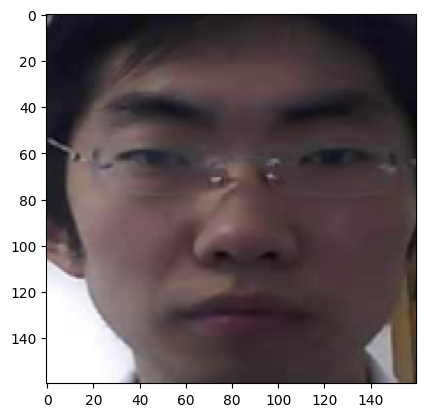

(160, 160, 3)


In [5]:
# code test
pixels = detect_face('../Dataset/CASIA-FASD/train/1/0_genuine.jpg')
plt.imshow(pixels)
plt.show()
print(pixels.shape)

In [6]:
def load_face(folder):
    faces = list() 
    for filename in os.listdir(folder):
        path = os.path.join(folder, filename)
        print(path)

        face = detect_face(path)
        if face is None:  # Skip if no face is detected
            continue
        faces.append(face)

    return faces

In [7]:
def load_dataset(folder):
    img = list()
    for subfolder in os.listdir(folder):
        sub = os.path.join(folder, subfolder)
        print(sub)
        faces, labels = load_face(sub)
        print("loaded %d sample for class: %s" % (len(faces),subfolder) ) # print progress
        
        img.extend(faces)

    return np.asarray(img)

In [8]:
# train_images = load_dataset(train_folder)
# test_images = load_dataset(test_folder)

In [9]:
def get_labels(folder):
    labels = list()
    for subfolder in os.listdir(folder):
        sub = os.path.join(folder, subfolder)
        # print(sub)
        for filename in os.listdir(sub):
            # thing = os.path.join(sub, filename)
            # print(filename)
            labels.append(filename)
            
    return labels

In [10]:
train_labels = get_labels(train_folder)
test_labels = get_labels(test_folder)

train_labels = [s.split('_')[1] for s in train_labels]
test_labels = [s.split('_')[1] for s in test_labels]

train_labels = [s.split('.')[0] for s in train_labels]
test_labels = [s.split('.')[0] for s in test_labels]

train_labels = [1 if label == 'genuine' else 0 for label in train_labels]
test_labels = [1 if label == 'genuine' else 0 for label in test_labels]

train_labels = np.asarray(train_labels)
test_labels = np.asarray(test_labels)

In [11]:
print(train_labels.shape)
print(test_labels.shape)

(1849,)
(2701,)


In [12]:
# np.savez_compressed('./new_train_data.npz', train_images, train_labels)
# np.savez_compressed('./new_test_data.npz', test_images, test_labels)

In [13]:
train_data = np.load('./new_train_data.npz')
test_data = np.load('./new_test_data.npz')

train_images, train_labels = train_data['arr_0'], train_data['arr_1']
test_images, test_labels = test_data['arr_0'], test_data['arr_1']

In [14]:
print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)
print(test_labels.shape)

(1849, 160, 160, 3)
(1849,)
(2701, 160, 160, 3)
(2701,)


train images shape : (1849, 160, 160, 3)
test images shape : (2701, 160, 160, 3)


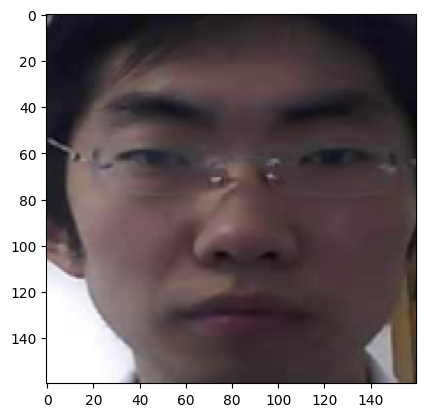

(160, 160, 3)


In [15]:
# test load
print(f'train images shape : {train_images.shape}')
print(f'test images shape : {test_images.shape}')

plt.imshow(train_images[0])
plt.show()
print(train_images[0].shape)

### FaceNet

In [16]:
from keras_facenet import FaceNet

In [17]:
embedder = FaceNet()

In [18]:
facenet_train_embeddings = embedder.embeddings(train_images)

58/58 [==============================] - 7s 71ms/step


In [19]:
facenet_test_embeddings = embedder.embeddings(test_images)

85/85 [==============================] - 5s 60ms/step


In [20]:
print(f'train embeddings shape : {facenet_train_embeddings.shape}')
print(f'test embeddings shape : {facenet_test_embeddings.shape}')

train embeddings shape : (1849, 512)
test embeddings shape : (2701, 512)


### RI-LBP

In [21]:
def rilbp(img):
    """
    Computes rotationally invariant local binary patterns for a grayscale image.

    Args:
        img: Input grayscale image (2D numpy array).

    Returns:
        RILBP image (2D numpy array).
    """
    # Get the number of rows and columns in the image
    rows, cols = img.shape

    # Create an empty array to store the RILBP values
    rilbp_img = np.zeros((rows, cols), dtype=np.uint8)

    # Define the 8 neighbors relative to the center pixel
    neighbors = [(-1, -1), (-1, 0), (-1, 1), (0, 1), 
                 (1, 1), (1, 0), (1, -1), (0, -1)]

    # Iterate over each pixel in the image, except the border pixels
    for i in range(1, rows - 1):
        for j in range(1, cols - 1):
            center = img[i, j]
            lbp_values = []

            # Compute LBP for all rotations
            for shift in range(8):
                binary_pattern = 0
                for k in range(8):
                    # Get neighbor coordinates, considering rotation
                    neighbor_x, neighbor_y = neighbors[(k + shift) % 8]
                    neighbor_value = img[i + neighbor_x, j + neighbor_y]

                    # Compare neighbor value with center
                    binary_pattern |= (neighbor_value >= center) << (7 - k)

                lbp_values.append(binary_pattern)

            # Find the minimum binary value among all rotations (rotation invariant)
            rilbp_value = min(lbp_values)
            rilbp_img[i, j] = rilbp_value

    return rilbp_img

In [22]:
def compute_rilbp_features(images):
    rilbp_features = []
    for img in images:
        # Convert image to grayscale if needed
        if len(img.shape) == 3:
            img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        # Compute RILBP
        rilbp_img = rilbp(img)
        # Flatten the RILBP image to a 1D feature vector
        rilbp_features.append(rilbp_img.flatten())
    return np.array(rilbp_features)

In [23]:
# rilbp_train_features = compute_rilbp_features(train_images)

In [24]:
rilbp_train_features_path = './Face Liveness/rilbp_train_features.npy'
# np.save(rilbp_train_features_path, rilbp_train_features)

In [25]:
rilbp_train_features = np.load(rilbp_train_features_path)

In [26]:
print(rilbp_train_features.shape)

(1849, 25600)


In [27]:
# rilbp_test_features = compute_rilbp_features(test_images)

In [28]:
rilbp_test_features_path = './Face Liveness/rilbp_test_features.npy'
# np.save(rilbp_test_features_path, rilbp_test_features)

In [29]:
rilbp_test_features = np.load(rilbp_test_features_path)

In [30]:
print(rilbp_test_features.shape)

(2701, 25600)


### Combine Features

In [32]:
combined_train_features = np.concatenate((facenet_train_embeddings, rilbp_train_features), axis=1)
combined_test_features = np.concatenate((facenet_test_embeddings, rilbp_test_features), axis=1)

In [35]:
print(combined_train_features.shape)
print(combined_test_features.shape)

(1849, 26112)
(2701, 26112)


### SVM

In [33]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

In [36]:
# Create an SVM classifier
svm_model = SVC(kernel='rbf', C=1.0, gamma='scale')

# Train the model on the training data
svm_model.fit(combined_train_features, train_labels)

SVC()

In [37]:
# Predict on the test data
y_pred = svm_model.predict(combined_test_features)

In [38]:
# Calculate accuracy
accuracy = accuracy_score(test_labels, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 84.19%
